In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
import re,string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
import time
import os
import shutil

from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [84]:
file = "./IMDB Dataset.csv"

df = pd.read_csv(file)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
#sentiment count
print("-----output counts------")
print(df['sentiment'].value_counts())

-----output counts------
sentiment
1    25000
0    25000
Name: count, dtype: int64


In [13]:
count_good=df[df['sentiment']==1]
count_bad=df[df['sentiment']==0]
print("First 10 samples of good reviews\n".format(),count_good[:5])
print("First 10 samples of bad reviews\n".format(),count_bad[:5])

First 10 samples of good reviews
                                                   review  sentiment
27120  I can't remember many details about the show, ...          1
42707  Breathtaking at it's best, intriguing at it's ...          1
2895   Excellent episode movie ala Pulp Fiction. 7 da...          1
40225  I really liked the movie, thought it was very ...          1
13206  Surprisingly good film made in the wake of the...          1
First 10 samples of bad reviews
                                                   review  sentiment
49382  1st watched 2/18/2007 - 4 out of 10(Dir-Leon L...          0
5499   The people at ABC forgot to do their biographi...          0
12415  Bela Lugosi plays Dr. Lorenz who loves his wif...          0
34148  Return of the Boogyman is a dreadful movie whi...          0
43526  This one is bad. A really bad and boring crime...          0


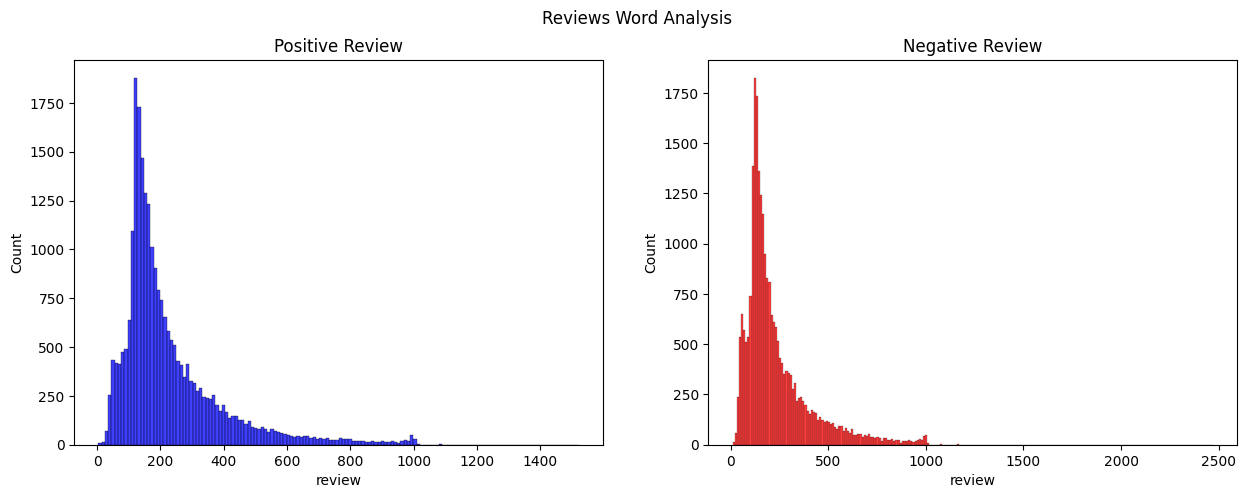

-----Word Count for Positive Reviews-----
 count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: review, dtype: float64


-----Word Count for Negative Reviews-----
 count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: review, dtype: float64


In [37]:
#Analyse the count of words in each segment- both positive and negative reviews
#Function for checking word length
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.histplot(count_zeros,ax=ax1,color='Blue')
    ax1.set_title(title_1)
    sns.histplot(count_ones,ax=ax2,color='Red')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


count_good_words=count_good['review'].str.split().apply(lambda z:cal_len(z))
count_bad_words=count_bad['review'].str.split().apply(lambda z:cal_len(z))
# print("Positive Review Words:" + str(count_good_words))
# print("Negative Review Words:" + str(count_bad_words))
plot_count(count_good_words,count_bad_words,"Positive Review","Negative Review","Reviews Word Analysis")
print("-----Word Count for Positive Reviews-----\n", count_good_words.describe())
print("\n")
print("-----Word Count for Negative Reviews-----\n", count_bad_words.describe())

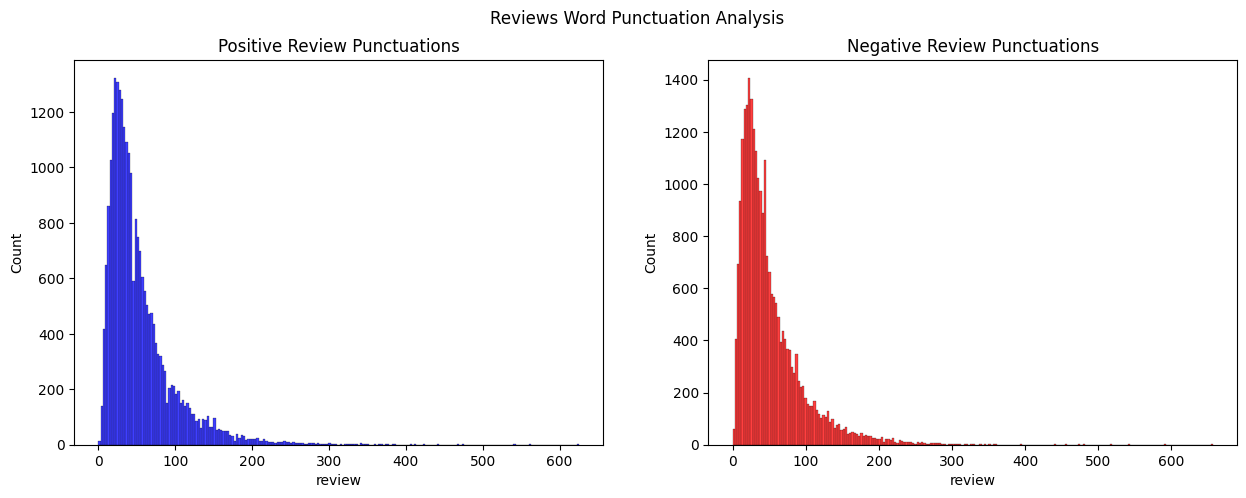

In [18]:
#Count Punctuations/Stopwords/Codes and other semantic datatypes
#We will be using the "generic_plotter" function.

count_good_punctuations=count_good['review'].apply(lambda z: len([c for c in str(z) if c in string.punctuation]))
count_bad_punctuations=count_bad['review'].apply(lambda z:len([c for c in str(z) if c in string.punctuation]))
plot_count(count_good_punctuations,count_bad_punctuations,"Positive Review Punctuations","Negative Review Punctuations","Reviews Word Punctuation Analysis")

<Axes: >

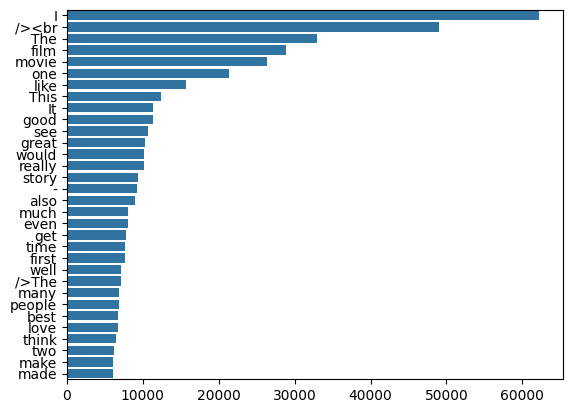

In [24]:
#Simplified counter function
def create_corpus(word):
    corpus=[]
    
    for x in df[df['sentiment']==word]['review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus(1)
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
stops=set(stopwords.words('english'))
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

#### The following can be inferred from the data:

- The dataset is balanced: 50% positive 50% negative.
- The dataset a few reviews that have over 600 words length (within 2 std).
- The dataset contains redundant words and html syntaxes.

##### Data Processing Method for Bag of Words and TFIDF:
- Remove punctuations, stopwords and html syntaxes
- Apply stemming to reduce the number of words


In [63]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

#set stopwords to english
stop=set(stopwords.words('english'))

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

In [40]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (40000,)
shape of test data is (10000,)


In [41]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
# cv=CountVectorizer()
cv_train_reviews=cv.fit_transform(x_train)
cv_test_reviews=cv.transform(x_test)
print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 7008271)
BOW_cv_test: (10000, 7008271)


In [42]:
#Tfidf vectorizer, ngrams at 3 worked the best
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(x_train)
#transformed test reviews
tv_test_reviews=tv.transform(x_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 7008271)
Tfidf_test: (10000, 7008271)


In [43]:
train_sentiments=y_train
test_sentiments=y_test

In [44]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments.ravel())
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments.ravel())
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [55]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)


In [56]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("Bag Of Words Accuracy: ",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("TF-IDF Accuracy :",lr_tfidf_score)

Bag Of Words Accuracy:  0.8467
TF-IDF Accuracy : 0.8832


In [58]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print("-----------Classification Report for Bag of Words----------\n")
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print("--------------Classification Report for TF-IDF-------------\n")
print(lr_tfidf_report)

-----------Classification Report for Bag of Words----------

              precision    recall  f1-score   support

    Positive       0.81      0.90      0.85      5000
    Negative       0.89      0.80      0.84      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

--------------Classification Report for TF-IDF-------------

              precision    recall  f1-score   support

    Positive       0.89      0.88      0.88      5000
    Negative       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [57]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print("Confusion Matrix for Bag of Words:\n", cm_bow)
print("\n")
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print("Confusion Matrix for TFIDF:\n", cm_tfidf)

Confusion Matrix for Bag of Words:
 [[3976 1024]
 [ 509 4491]]


Confusion Matrix for TFIDF:
 [[4452  548]
 [ 620 4380]]


In [5]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:1")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Using an LSTM Neural Network to do Sequence Classification

- This can help find context and meaning in a review that is more than just counting the words
- Need to do data pre-processing again (turns out some pre-processing steps make the model perform worse such as removing punctuation or stemming and lemmatizing)
- In order to using batch training, we must add padding and also truncate some reviews to 512 tokens. However, this is okay as we saw above that a minority of reviews are > 512

In [34]:
###### LSTM ######
file = "./IMDB Dataset.csv"

df = pd.read_csv(file)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#Apply strip html to function on review column
df['review']=df['review'].apply(strip_html)
df.head()

In [36]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (40000,)
shape of test data is (10000,)


In [37]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)  
    
    return s

def tokenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)
    # corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return final_list_train, encoded_train, final_list_test, encoded_test,onehot_dict

In [38]:
x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 187044


In [39]:
#pre-pend the padding worked the best
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    sentence_len = [len(sentence) if len(sentence) <= seq_len else seq_len for sentence in sentences]
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features, sentence_len

#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,600)
# x_train_pad = torch.tensor(padding_(x_train,600))
# x_test_pad = torch.tensor(padding_(x_test,600))
x_test_pad = padding_(x_test,600)

In [40]:
class IMDB_Sentiment_Dataset(Dataset):
    def __init__(self, x_dataset, y_dataset):
        self.x_dataset = x_dataset[0]
        self.y_dataset = y_dataset
    def __len__(self):
        return len(self.x_dataset)
    
    def __getitem__(self, idx):
       return self.x_dataset[idx], self.y_dataset[idx]

train_data = IMDB_Sentiment_Dataset(x_train_pad, torch.tensor(y_train))
valid_data = IMDB_Sentiment_Dataset(x_test_pad, torch.tensor(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [41]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5, output_dim=1):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [54]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
drop_prob = 0.3

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob, output_dim)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(187045, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [55]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [56]:
clip = 1
epochs = 6 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6722924875840545 val_loss : 0.5855767017602921
train_accuracy : 56.5175 val_accuracy : 68.62
Validation loss decreased (inf --> 0.585577).  Saving model ...
Epoch 2
train_loss : 0.45180549095384775 val_loss : 0.4738264022022486
train_accuracy : 79.4275 val_accuracy : 80.97999999999999
Validation loss decreased (0.585577 --> 0.473826).  Saving model ...
Epoch 3
train_loss : 0.2961770615633577 val_loss : 0.3260146504640579
train_accuracy : 88.00750000000001 val_accuracy : 86.17
Validation loss decreased (0.473826 --> 0.326015).  Saving model ...
Epoch 4
train_loss : 0.20476245062425733 val_loss : 0.32391172505915167
train_accuracy : 92.2425 val_accuracy : 87.26
Validation loss decreased (0.326015 --> 0.323912).  Saving model ...
Epoch 5
train_loss : 0.1408761413069442 val_loss : 0.34601108226925137
train_accuracy : 95.0125 val_accuracy : 86.36
Epoch 6
train_loss : 0.09060222022410017 val_loss : 0.4099262062460184
train_accuracy : 97.0775 val_accuracy : 87.33


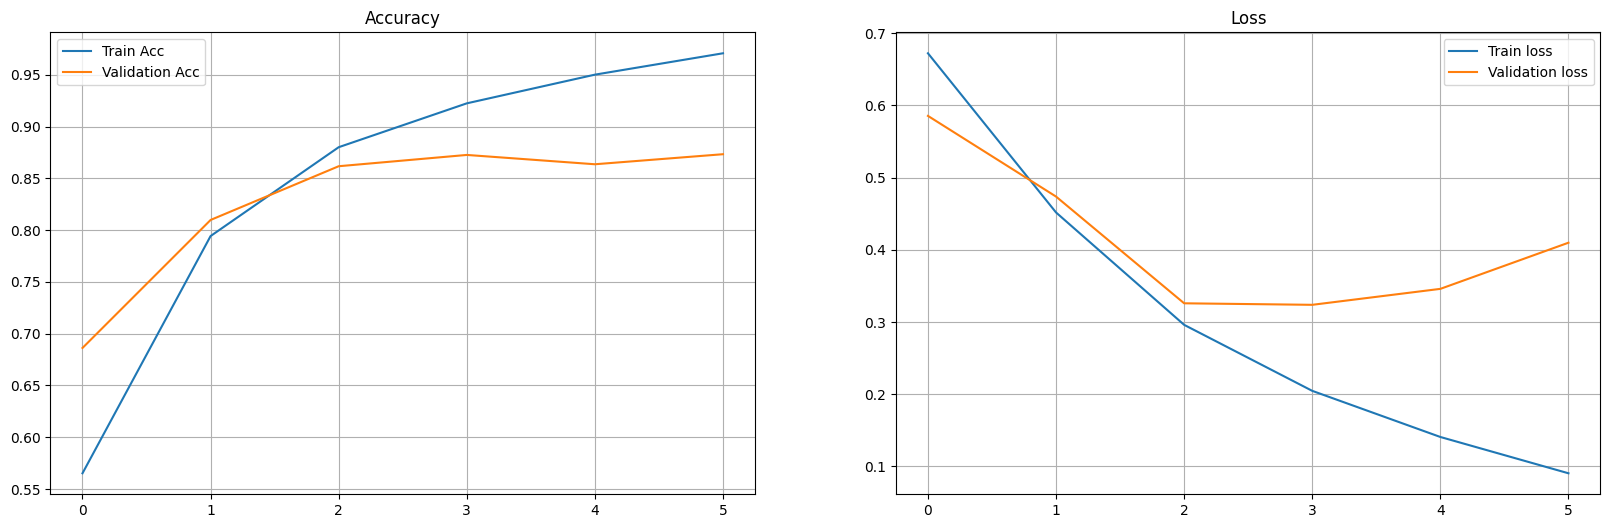

In [61]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [60]:
print("Best Validation Accuracy: ", max(epoch_vl_acc))

Best Validation Accuracy:  0.8733


### Transformer Fine Tuning using BERT
- Transformers model pretrained on a large corpus of English data with attention can improve perform for longer reviews
- I tried using *nlptown/bert-base-multilingual-uncased-sentiment* for this sequence classification and it performed pretty well out of the box at ~88%
- This is an attempt to try and get a better performance by fine tuning a vanilla BERT model
- Similarly, we need to pre-process the data again as various processing steps make the model perform worse (such as stemming and lemmatization)

In [2]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r' ',data)
    return data

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removes HTML syntaxes
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data


In [ ]:
root_model_path = os.path.join("./logs/", 'best_fine_tune_bert')
base_csv = './IMDB Dataset.csv'
df = pd.read_csv(base_csv)
cleaned_df = df
cleaned_df['sentiment'] = cleaned_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
cleaned_df['review']=cleaned_df['review'].apply(lambda z: strip_html(z))
cleaned_df['review']=cleaned_df['review'].apply(lambda z: remove_punctuations(z))

cleaned_df['review']=cleaned_df['review'].apply(lambda z: remove_html(z))
cleaned_df['review']=cleaned_df['review'].apply(lambda z: remove_url(z))
cleaned_df['review']=cleaned_df['review'].apply(lambda z: remove_emoji(z))
cleaned_df.head(5)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
).to(device)

optim = torch.optim.AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [7]:
X,y = cleaned_df['review'].values, cleaned_df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

x_train_list = X_train.tolist()
x_test_list  = X_test.tolist()
x_val_list   = X_val.tolist()

y_train_list = y_train.tolist()
y_test_list  = y_test.tolist()
y_val_list   = y_val.tolist()

In [8]:
train_encodings = tokenizer(x_train_list, truncation=True, padding=True)
val_encodings = tokenizer(x_val_list, truncation=True, padding=True)
test_encodings = tokenizer(x_test_list, truncation=True, padding=True)

In [9]:
class IMDb_Dataset__For_BERT(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDb_Dataset__For_BERT(train_encodings, y_train_list)
val_dataset = IMDb_Dataset__For_BERT(val_encodings, y_val_list)
test_dataset = IMDb_Dataset__For_BERT(test_encodings, y_test_list)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [10]:
def save_model(root_model_path):
    if os.path.exists(root_model_path) and os.path.isdir(root_model_path):
        shutil.rmtree(root_model_path, ignore_errors=True)
    tokenizer.save_pretrained(root_model_path)
    model.save_pretrained(root_model_path)
    
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train(model, num_epochs, train_loader, valid_loader, root_model_path):    
    training_losses = []
    validation_losses = []
    best_eval_accuracy = 0
    
    for epoch in range(num_epochs):
        training_loss = 0.0
        total_train_accuracy = 0.0
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for _, batch in enumerate(tk0):
            optim.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask= attention_mask, labels = labels)
            loss = outputs.loss
            loss.backward()
            optim.step()

            training_loss += loss.item()
            # check acc
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            total_train_accuracy += flat_accuracy(logits, label_ids)

            #update tqdm
            tk0.set_postfix(loss=training_loss)
            time.sleep(0.1)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        print(" Avg Train Accuracy: {0:.2f}".format(avg_train_accuracy))
        #validation loss
        valid_loss= 0.0
        total_eval_accuracy = 0.0
        model.eval()
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask= attention_mask, labels = labels)
            loss = outputs.loss
            valid_loss += loss.item() 
            # check acc
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)
        avg_val_accuracy = total_eval_accuracy / len(valid_loader)
        print(" Avg Val Accuracy: {0:.2f}".format(avg_val_accuracy))
        if avg_val_accuracy > best_eval_accuracy:
            print("Saving Model...")
            save_model(root_model_path)
            best_eval_accuracy = avg_val_accuracy
        avg_train_loss = training_loss / len(train_loader)
        avg_val_loss = valid_loss / len(valid_loader)
        
        training_losses.append(avg_train_loss)
        validation_losses.append(avg_val_loss)
    return training_losses, validation_losses

def plot_stats(training_losses, validation_losses):
    e = len(training_losses)
    x_axis = np.arange(1, e + 1, 1)
    plt.figure()
    plt.plot(x_axis, training_losses, label="Training Loss")
    plt.plot(x_axis, validation_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.legend(loc='best')
    plt.title("Stats Plot")
    plt.savefig(os.path.join("./", "stat_plot.png"))
    plt.show()

In [11]:
##train
model = model.to(device)
num_epochs = 3
training_losses, validation_losses = train(model, num_epochs, train_dataloader, eval_dataloader, root_model_path)

100%|██████████| 3750/3750 [18:17<00:00,  3.42it/s, loss=1.04e+3]


 Avg Train Accuracy: 0.89
 Avg Val Accuracy: 0.92
Saving Model...


100%|██████████| 3750/3750 [18:16<00:00,  3.42it/s, loss=590]


 Avg Train Accuracy: 0.94
 Avg Val Accuracy: 0.89


100%|██████████| 3750/3750 [18:11<00:00,  3.44it/s, loss=2.4e+3] 


 Avg Train Accuracy: 0.54
 Avg Val Accuracy: 0.50


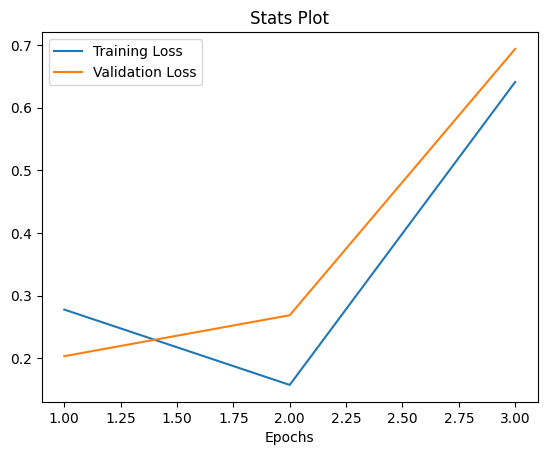

In [12]:
plot_stats(training_losses, validation_losses)

In [ ]:
#load best model
tokenizer = AutoTokenizer.from_pretrained(root_model_path)
model = AutoModelForSequenceClassification.from_pretrained(root_model_path)
model = model.to(device)
model.eval()

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

with torch.no_grad():
    loss_list = []
    preds_list = []
    accuracy_list = []
    accuracy_sum = 0
    for batch in tqdm(test_dataloader):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs[0]
      logits = F.softmax(outputs[1], dim=1)   # Taking the softmax of output
      _,preds = torch.max(logits, dim=1)      # Taking the predictions of our batch
      acc = accuracy(logits,labels)           # Calculating the accuracy of current batch
      accuracy_sum += acc                     # Taking sum of all the accuracies of all the batches. This sum will be divided by batch length to get mean accuracy

      loss_list.append(loss)
      preds_list.extend(preds.tolist())
      accuracy_list.append(acc)

mean_accuracy = accuracy_sum / len(test_dataloader)
mean_accuracy

  0%|          | 2/1250 [00:00<01:24, 14.82it/s]

100%|██████████| 1250/1250 [01:20<00:00, 15.62it/s]


tensor(0.9222)

In [39]:
print("--------Classification Report for BERT Fine Tuning--------")
print(classification_report(y_test_list,preds_list,target_names=['Positive','Negative']))
print("\n")
print("-----------Confusion Matrix for BERT Fine Tuning-----------")
print(confusion_matrix(y_test_list,preds_list,labels=[1,0]))


--------Classification Report for BERT Fine Tuning--------
              precision    recall  f1-score   support

    Positive       0.93      0.91      0.92      5000
    Negative       0.91      0.93      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



-----------Confusion Matrix for BERT Fine Tuning-----------
[[4656  344]
 [ 434 4566]]


### Summary 
- The data was overall very good and so a simple logistic regression model performed very well.
- LSTM model performed a bit worse than the simple TD-IDF model perhaps because some of the reviews were too long and created noise. RNN models tend to show hallucinations when the context gets too long. 
- BERT fine tuning model did the best of the three but it took a lot of resources and time since the model is so much larger than the vanilla LSTM

### Further Improvements
- Attempt different data pre-processing methods
- Hyperparameter Tuning for LSTM and BERT
- Add Bi-directionality for LSTM, add attention layer
- Use Different Transformer models

### What I Learned
- Pre-processing data and feature engineering is just as important as the model itself (# of ngrams, lemmatizing, stemming, etc.)
- For LSTM, prepadding performs way better than the default post-padding (55% vs 88% acc)
- For BERT, fine tuning can turn a poor performing model into a very good one